In [1]:
import pandas as pd 
import numpy as np 
import pickle
import os
import helper_functions as hf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 

In [2]:
data_dir = 'C:/Users/mk344/OneDrive - Drexel University/Drexel courses/Fall Quarter 2019-2020/ECEC 487/microbiome_glove_embedding/data'
fig_dir = 'C:/Users/mk344/OneDrive - Drexel University/Drexel courses/Fall Quarter 2019-2020/ECEC 487/microbiome_glove_embedding/figures'

In [3]:
# data for classisifaction on embeddings based on sample
f = open(os.path.join(data_dir, "X_sample_property.obj"), "rb")
X = pickle.load(f)
f.close()
f = open(os.path.join(data_dir, "y_sample_ibd.obj"), "rb")
y = pickle.load(f)
f.close()
y = list(y[0].values)

In [8]:
# creating the train and test dataset
X_train_embedding, X_test_embedding, y_train_embedding, y_test_embedding = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# f = open(os.path.join(data_dir, "map_filter.07_ml.csv"), "rb")
# map_filt = pickle.load(f)
# f.close()

In [9]:
# classifying the data using KNN
neigh_f1 = KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,weights='uniform')
neigh_f2 = KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')
neigh_f05 = KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=17, p=2,
                     weights='uniform')       
mdl_embedding = neigh_f05.fit(X_train_embedding, y_train_embedding)
# mdl_otu = neigh.fit(X_train_otu, y_train_otu)

In [11]:
import csv
y_test_csv = [y_test_embedding]
y_predict_csv = [y_predict_embedding]
with open('./y_test_knn_f05.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(y_test_csv)
with open('./y_predict_knn_f05.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(y_predict_csv)

In [10]:
from sklearn.metrics import accuracy_score
y_predict_embedding = mdl_embedding.predict(X_test_embedding)
acc_score_embedding = accuracy_score(y_test_embedding, y_predict_embedding)
print('embedding score:', acc_score_embedding)

embedding score: 0.9625531914893617


F1 0.45000000000000007


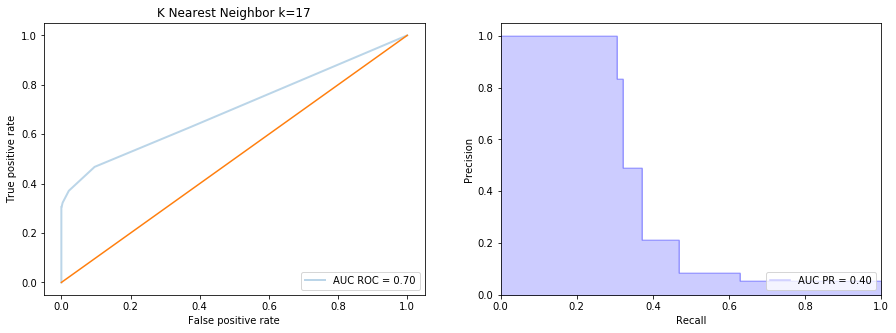

In [12]:
f = plt.figure(figsize=(15,5))
roc_auc, fpr, tpr, average_precision, f1, f2 = hf.computeMLstats(mdl_embedding, X_test_embedding, y_test_embedding, plot=True, plot_pr=True, graph_title = "K Nearest Neighbor k=17", flipped = False)
print('F1', f1)
f.savefig(os.path.join(fig_dir, "embed_data_knn_classifier_k17_f05.png"))

In [7]:
# Stratification
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=10)
scv = StratifiedKFold(n_splits=10)
for metric in metric_names:
    score1 = cross_val_score(neigh, X, y, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(neigh, X, y, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]
print(scores_df)

Random-CV Stratified-CV
f1                 0.478905      0.481945
roc_auc            0.688266      0.692289
average_precision  0.385477       0.38779
accuracy           0.962718      0.962721
precision           0.93697      0.939261
recall             0.326684      0.328427


In [7]:
max(cv_scores)

0.6818217936624915

In [4]:
# knn tuning with cross validation score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
scv = StratifiedKFold(n_splits=10)
# creating odd list of K for KNN
neighbors = list(range(1, 40, 2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
ftwo_scorer = make_scorer(fbeta_score, beta=0.5)
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=scv, scoring=ftwo_scorer)
    cv_scores.append(scores.mean())

The optimal number of neighbors is 17


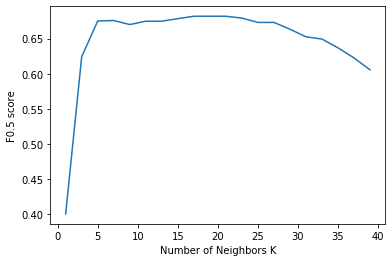

<Figure size 1080x360 with 0 Axes>

In [6]:
# changing to misclassification error
mse = [x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(max(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("F0.5 score")
plt.show()
f = plt.figure(figsize=(15,5))
# f.savefig(os.path.join(fig_dir, "optimal_kf1.jpg"))
f.savefig(os.path.join(fig_dir, "optimal_kf05.png"))

In [10]:
# Hyperparameter tuning
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
knn = KNeighborsClassifier(n_jobs=-1)
scv = StratifiedKFold(n_splits=10)
#Hyper Parameters Set
ftwo_scorer = make_scorer(fbeta_score, beta=2)
k_range = list(range(1, 15, 2 ))
params = {'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
params['n_neighbors'] = k_range
grid = GridSearchCV(knn, param_grid=params, cv=scv, scoring=ftwo_scorer,n_jobs = -1)

In [11]:
grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 5], 'n_jobs': [-1],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [12]:
# view the complete results (list of named tuples)
grid.cv_results_

       , 0.5       , 0.5       ,
        0.5       , 0.51162791, 0.51162791, 0.51162791, 0.51162791,
        0.37681159, 0.37681159, 0.45833333, 0.45833333, 0.48888889,
        0.48888889, 0.5       , 0.5       , 0.5       , 0.5       ,
        0.51162791, 0.51162791, 0.51162791, 0.51162791]),
 'split6_test_score': array([0.28571429, 0.28571429, 0.30769231, 0.30769231, 0.31578947,
        0.31578947, 0.31578947, 0.31578947, 0.31578947, 0.31578947,
        0.31578947, 0.31578947, 0.31578947, 0.31578947, 0.28571429,
        0.28571429, 0.30769231, 0.30769231, 0.31578947, 0.31578947,
        0.31578947, 0.31578947, 0.31578947, 0.31578947, 0.31578947,
        0.31578947, 0.31578947, 0.31578947, 0.28571429, 0.28571429,
        0.30769231, 0.30769231, 0.31578947, 0.31578947, 0.31578947,
        0.31578947, 0.31578947, 0.31578947, 0.31578947, 0.31578947,
        0.31578947, 0.31578947, 0.28571429, 0.28571429, 0.30769231,
        0.30769231, 0.31578947, 0.31578947, 0.31578947, 0.31578947,
    

In [12]:
# create a list of the mean scores only
# list comprehension to loop through grid.grid_scores
grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

[0.38001649 0.38001649 0.36848778 0.36848778 0.37614675 0.37614675
 0.36987404 0.36987404 0.36637003 0.36637003 0.36367383 0.36691929
 0.36367383 0.36367383 0.38001649 0.38001649 0.36848778 0.36848778
 0.37614675 0.37614675 0.36987404 0.36987404 0.36637003 0.36637003
 0.36367383 0.36691929 0.36367383 0.36367383 0.38001649 0.38001649
 0.36848778 0.36848778 0.37614675 0.37614675 0.36987404 0.36987404
 0.36637003 0.36637003 0.36367383 0.36691929 0.36367383 0.36367383
 0.38001649 0.38001649 0.36848778 0.36848778 0.37614675 0.37614675
 0.36987404 0.36987404 0.36637003 0.36637003 0.36367383 0.36691929
 0.36367383 0.36367383 0.38001649 0.38001649 0.36848778 0.36848778
 0.37614675 0.37614675 0.36987404 0.36987404 0.36637003 0.36637003
 0.36367383 0.36691929 0.36367383 0.36367383 0.38001649 0.38001649
 0.36848778 0.36848778 0.37614675 0.37614675 0.36987404 0.36987404
 0.36637003 0.36637003 0.36367383 0.36691929 0.36367383 0.36367383
 0.38001649 0.38001649 0.36848778 0.36848778 0.37614675 0.3761

In [17]:
# plot the results
# this is identical to the one we generated above
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F1 score')
f = plt.figure(figsize=(15,5))
f.savefig(os.path.join(fig_dir, "optimal_k_cross_val.png"))

ValueError: x and y must have same first dimension, but have shapes (7,) and (224,)

In [13]:
# examine the best model

# Single best score achieved across all params (k)
print(grid.best_score_)

# Dictionary containing the parameters (k) used to generate that score
print(grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid.best_estimator_)

0.3800164869255728
{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')


In [ ]:
# Performance Metrics
from sklearn import metrics
train_idx, test_idx = scv.split(X, y).next()
# clf = RandomForestClassifier(n_estimators=10, random_state=RNG)

neigh.fit(X[train_idx], y[train_idx])
print X[train_idx].shape, X[test_idx].shape
y_probas = clf.predict_proba(X[test_idx])[:,1]
y_preds = clf.predict(X[test_idx])

## confusion matrix
print '--confusion matrix--'
cm = metrics.confusion_matrix(y[test_idx], y_preds, labels=[0,1])
print cm
print '--classification report --'
print metrics.classification_report(y[test_idx], y_preds, labels=[0,1])

In [ ]:
# Metrics of the rare class
print metrics.recall_score(y[test_idx], y_preds, pos_label=0)
print metrics.recall_score(y[test_idx], y_preds, pos_label=1)

In [ ]:
# plot scores across thresholds
fig, ax = plt.subplots()

fpr, tpr, thresholds = metrics.roc_curve(y[test_idx], y_probas)
ax.plot(fpr, tpr, color=COLORS10[0])

ax.legend(loc='best')
ax.set_xlabel('FPR', fontsize=16)
ax.set_ylabel('TPR', fontsize=16)
print 'AUROC = %.6f' % metrics.auc(fpr, tpr)
print 'Accuracy = %.6f' % metrics.accuracy_score(y[test_idx], y_preds)

In [ ]:
# plot scores across thresholds
fig, ax = plt.subplots()

pr, rc, thresholds = metrics.precision_recall_curve(y[test_idx], y_probas)
ax.plot(pr, rc, color=COLORS10[0])

ax.legend(loc='best')
ax.set_xlabel('Precision', fontsize=16)
ax.set_ylabel('Recall', fontsize=16)
print 'AUPRC = %.6f' % metrics.average_precision_score(y[test_idx], y_probas)
print 'Accuracy = %.6f' % metrics.accuracy_score(y[test_idx], y_preds)